In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import zipfile
import time
from PIL import Image
from tqdm import tqdm

d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
from src.setupData import load_voc_dataset, _parse_features, load_coco_dataset
from src.augmentations import RandomHorizontalFlip, RandomMirror, RandomZoom, RandomTranslate, AddNoise, GaussianBlur, RandomGamma, RandomRotate, AugProbability, Converter, Ada, build_augmenter
from src.utils import visualize_boxes, visualize_outputs, plot_grid_anchors
from tools.read_tfRecord import read_tfrecord, get_tfrecordkeys
from models.bbox_preprocess import TransformBoxes
from models.loss import lossFunction

# Data Augmentation

In [3]:
class args:
    img_size = (256, 256)
    buffer_size = 64
    batch_size = 16
    epochs = 100
    NUM_CLASSES = 80
    max_output_size = 50
    max_output_size_per_class= 30
    iou_threshold = 0.5
    confidence_threshold = 0.5
    ignore_thresh=0.5
    lambda_box = 5
    lambda_noobj = 0.5
    lambda_class = 1

grid_sizes = [8, 16, 32] # [8, 16, 32], [13, 26, 52]
NORMALIZED_ANCHORS = [[(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
                      [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
                      [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)]]

yolo_anchors = tf.constant([[(116, 90), (156, 198), (373, 326)],
                            [(30, 61), (62, 45), (59, 119)], 
                            [(10, 13), (16, 30), (33, 23)]], tf.float32) / 416.

voc_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_train.tfrecord"
voc_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_val.tfrecord"
coco_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord"
coco_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord"
img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png'

translate = 0.2
rot = 40
scale = 0.35
kernel_size = 5
sigma = 1
augmentations = [
    RandomHorizontalFlip(), 
    RandomTranslate(translate=translate), 
    RandomRotate(rot=rot), 
    RandomZoom(scale=scale), 
    RandomMirror(), 
    AddNoise(), 
    RandomGamma(), 
    GaussianBlur(kernel_size=kernel_size, sigma=sigma)
]

In [4]:
ds_train = load_coco_dataset(args, coco_train_ds_path, augment_func = None, split = 'train')
# ds_train = load_voc_dataset(args, voc_train_ds_path, None, 'train')

Loading train dataset from D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord...


In [5]:
tmvm = iter(ds_train)

In [6]:
kvsdk = next(tmvm)

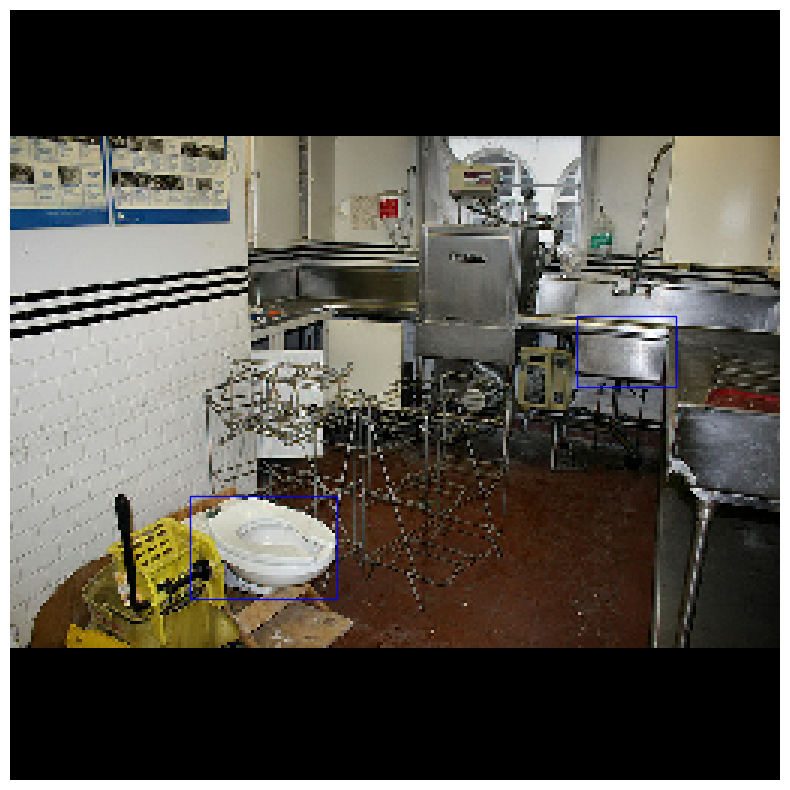

In [7]:
i = 0
img_to_test = kvsdk[0][i]
its_bboxes = kvsdk[1][i]
img_y = img_to_test.shape[0]
img_x = img_to_test.shape[1]
scale = tf.constant([img_y, img_x, img_y, img_x], dtype=tf.float32)
visualize_boxes(img_to_test, its_bboxes[..., :-1]*scale, figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [9]:
setup_bboxes = TransformBoxes(grid_sizes, yolo_anchors)
# setup_bboxes = BboxesToAnchors(grid_sizes, yolo_anchors, img_shape)

In [10]:
grid = setup_bboxes(kvsdk[1])

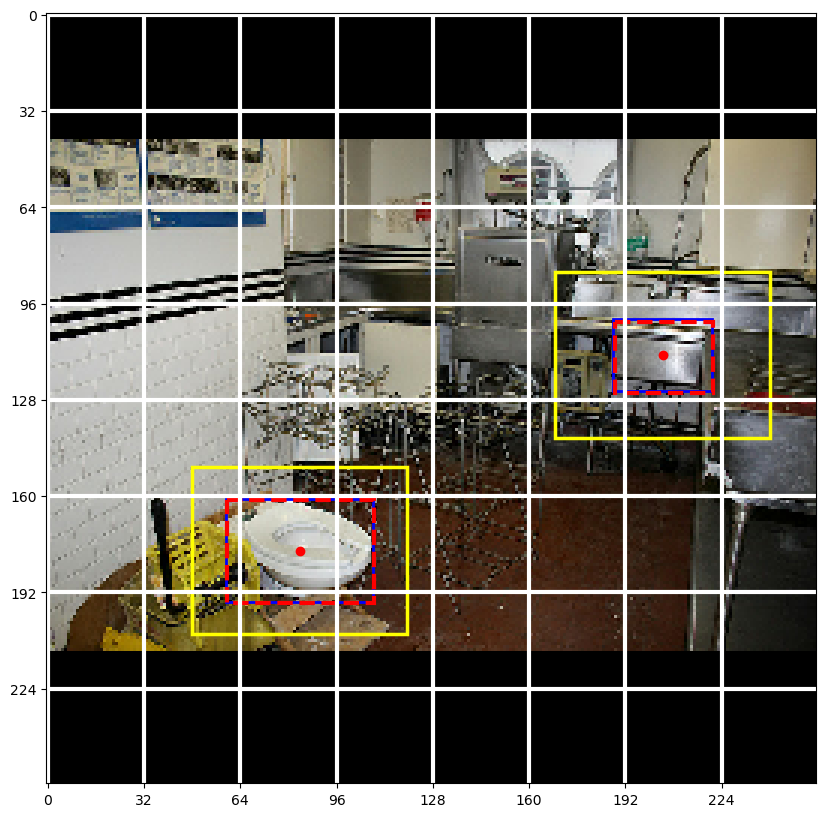

Total bboxes: 2, Total anchors: 2


In [11]:
c = 0
plot_grid_anchors(img_to_test, its_bboxes, grid[c], (10, 10), yolo_anchors[c], False, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Make Sure Augmentations Work

In [ ]:
# augment_func = build_augmenter(aug_functions=augmentations, img_size=args.img_size)
# dkl = tf.repeat(tf.Variable([[0.5]]), kvsdk[0].shape[0])
# aug_bbox_input, obj_class_saved = tf.split(kvsdk[1], [4, 1], axis=-1)
# test_aug = augment_func((kvsdk[0], aug_bbox_input, dkl))
# visualize_outputs(test_aug[0], test_aug[1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [15]:
augmenter = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [16]:
augmenter.update(tf.constant(0.2))
print(augmenter.probability)
test_ada = augmenter(kvsdk, training=True)

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.639371]], dtype=float32)>


In [ ]:
# visualize_outputs(test_ada[0], test_ada[1][..., :-1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [17]:
grid2 = setup_bboxes(test_ada[1])

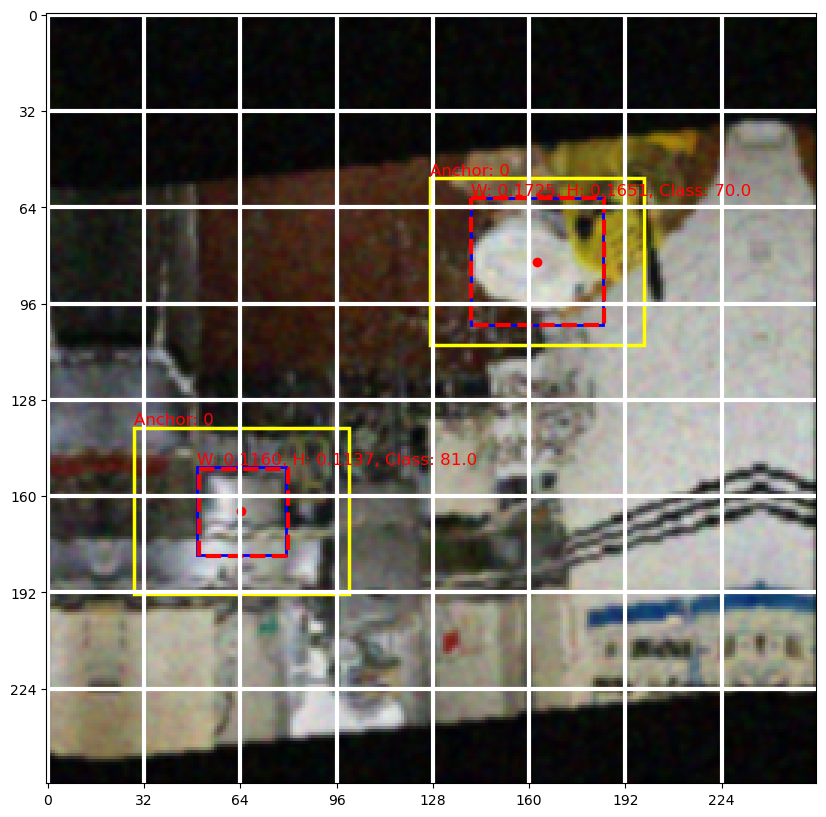

Total bboxes: 2, Total anchors: 2


In [18]:
c = 0
plot_grid_anchors(test_ada[0], test_ada[1], grid2[c], (10, 10), yolo_anchors[c], True, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Model Architecture

In [34]:
def make_dummy_model(img_size, grid_sizes, classes = args.NUM_CLASSES, num_anchors = 3):

    if len(img_size) == 2:
        shape = (img_size[0], img_size[1], 3)
    if len(img_size) == 3:
        shape = img_size
    
    inputs = tf.keras.Input(shape=shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", name='Conv1')(inputs)
    x = layers.BatchNormalization(name='BN1')(x)
    x = layers.Activation("relu", name='Act1')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=4, padding="same", name='Conv2')(x)
    x = layers.BatchNormalization(name='BN2')(x)
    x = layers.Activation("relu", name='Act2')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=4, padding="same", name='Conv3')(x)
    x = layers.BatchNormalization(name='BN3')(x)
    x = layers.Activation("relu", name='Act3')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", name='Conv4')(x)
    x = layers.BatchNormalization(name='BN4')(x)
    x = layers.Activation("relu", name='Act4')(x)

    filters = num_anchors * (4 + 1 + classes)
    x = layers.Conv2D(filters=filters, kernel_size=1, activation="sigmoid", padding="same", name='FinalConv1')(x)
    out1 = layers.Reshape((grid_sizes[0], grid_sizes[0], num_anchors, classes + 5))(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters=filters, kernel_size=1, activation="sigmoid", padding="same", name='FinalConv2')(x)
    out2 = layers.Reshape((grid_sizes[1], grid_sizes[1], num_anchors, classes + 5))(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters=filters, kernel_size=1, activation="sigmoid", padding="same", name='FinalConv3')(x)
    out3 = layers.Reshape((grid_sizes[2], grid_sizes[2], num_anchors, classes + 5))(x)

    model = tf.keras.Model(inputs=inputs, outputs=[out1, out2, out3])
    return model

In [64]:
class MyModel(tf.keras.Model):

    def __init__(self, 
                 img_size,
                 augment_func,
                 grid_sizes,
                 anchors,
                 **kwargs):
               
        super(MyModel, self).__init__(**kwargs)

        self.img_size = img_size
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.model = make_dummy_model(img_size, grid_sizes)
        self.transformBoxes = TransformBoxes(grid_sizes=grid_sizes, anchors=anchors)
        self.ada = augment_func

    def compile(self, optimizer=None, metrics=[], *args, **kwargs):

        assert isinstance(metrics, list), "metrics input must be a list"
        self.train_step_counter.assign(0)
        self.optimizer = optimizer

        # Set up MyModel._metrics
        self.augmentation_probability_tracker = tf.keras.metrics.Mean(name="aug_probability")
        
        # Set up MyModel.compiled_metrics._metrics
        super(MyModel, self).compile(metrics=metrics, *args, **kwargs)

    @property
    def metrics(self):

        if self.compiled_metrics.built:
            return self.compiled_metrics._metrics[0] + [self.augmentation_probability_tracker]
        else:
            return [self.augmentation_probability_tracker]

    def train_step(self, ds_input):

        # ds_input - image (BS, H, W, C), bboxes (BS, N, 5)

        self.train_step_counter.assign_add(1)
        augmented_images, augmented_bboxes = self.ada(ds_input, training=True)
        # augmented_images - (BS, H, W, C), augmented_bboxes - (BS, N, 5)

        grid_aug_bboxes = self.transformBoxes(augmented_bboxes)
        # grid_aug_bboxes - (BS, gy, gx, num_anchors, 6) x 3
        
        with tf.GradientTape() as tape: # target tensor must be tf.float32

            predicted = self.model(augmented_images, training=True) # out: tf.float32 (BS, gy, gx, num_anchors, 6) <- in: tf.float32
            loss = self.compiled_loss(grid_aug_bboxes, predicted) # out: tf.float32 <- in: tf.float32, tf.float32
            
        trainable_weights = self.model.trainable_weights
        model_grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(model_grads, trainable_weights))
        
        self.ada.update(loss)
        self.compiled_metrics.update_state(loss)
        self.augmentation_probability_tracker.update_state(self.ada.probability)
        
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False, augment=False):

        augmented_images, augmented_masks = self.ada(inputs, training=training) if augment else inputs
        predicted = self.model(augmented_images, training=training)
        return augmented_images, augmented_masks, predicted

In [65]:
loss1 = lossFunction(yolo_anchors[0], args.NUM_CLASSES, args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
loss2 = lossFunction(yolo_anchors[1], args.NUM_CLASSES, args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
loss3 = lossFunction(yolo_anchors[2], args.NUM_CLASSES, args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
augment_func = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [66]:
test_mymodel = MyModel(img_size=(256, 256), augment_func=augment_func, grid_sizes=grid_sizes, anchors=yolo_anchors)

In [67]:
test_mymodel.compile(optimizer='adam', metrics=[tf.keras.metrics.MeanIoU(num_classes=4, name='meanIOU'), 'bce'], loss=[loss1, loss2, loss3])

In [ ]:
test_mymodel.fit()

In [69]:
# test_mymodel.metrics_names

In [61]:
# test_mymodel.compiled_metrics.update_state(tf.constant([2.0]))

In [62]:
# vars(test_mymodel.compiled_metrics)

In [63]:
# test_mymodel.metrics

# Callback

In [ ]:
# Setup Callbacks

# Configuration

In [ ]:
# class Config(object):
#     """
#     Holds the configuration for anything you want it to.
#     To get the currently active config, call get_cfg().

#     To use, just do cfg.x instead of cfg['x'].
#     I made this because doing cfg['x'] all the time is dumb.
#     """

#     def __init__(self, config_dict):
#         for key, val in config_dict.items():
#             self.__setattr__(key, val)

#     def copy(self, new_config_dict={}):
#         """
#         Copies this config into a new config object, making
#         the changes given by new_config_dict.
#         """

#         ret = Config(vars(self))
        
#         for key, val in new_config_dict.items():
#             ret.__setattr__(key, val)

#         return ret

#     def replace(self, new_config_dict):
#         """
#         Copies new_config_dict into this config object.
#         Note: new_config_dict can also be a config object.
#         """
#         if isinstance(new_config_dict, Config):
#             new_config_dict = vars(new_config_dict)

#         for key, val in new_config_dict.items():
#             self.__setattr__(key, val)
    
#     def print(self):
#         for k, v in vars(self).items():
#             print(k, ' = ', v)

# Train

In [ ]:
def setupModel(args, dummy=False):
  
    params = {'anchors': args.anchors, 'classes': args.classes, 
            'projection_dim': args.projection_dim, 'num_heads': args.num_heads, 
            'patch_size_ratio': 1/args.patch_size_ratio, 'img_size': args.img_size}
  

    mymodel = make_dummy_model(params['img_size'])

    model_dir = 'weights/'

    if args.visualize_training == 1:

        sample_img = tf.keras.utils.load_img(os.path.join(os.getcwd(), 'img.png'))
        input_arr = tf.keras.utils.img_to_array(sample_img, data_format='channels_last')
        input_arr = tf.image.resize(input_arr, size=args.img_size, method='nearest')
        example_img = tf.convert_to_tensor(input_arr / 255)

        weights_path = os.path.join(os.getcwd(), model_dir, "weights_epoch_{epoch}")
        print(f"Storing weights at {weights_path}")

        callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, 
                                                                monitor="loss", 
                                                                save_best_only=False, 
                                                                save_weights_only=True, 
                                                                verbose=1), DisplayCallback(example_img)]
    else: 

        callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(), "weights_epoch_{epoch}"), 
                                                                monitor="loss", 
                                                                save_best_only=False, 
                                                                save_weights_only=True, 
                                                                verbose=1)]

    if args.optimizer == 'scd':

        learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
        learning_rate_boundaries = [125, 250, 500, 240000, 360000]

        learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

    if args.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-06)

    return mymodel, customLoss, callbacks_list, optimizer

# Extra

In [ ]:
    #   count_pos_values = tf.math.count_nonzero(bboxes, axis=-1, dtype=tf.float32) # Count num of nonzeros in the rows
    #   rows_to_keep = tf.clip_by_value(count_pos_values, 0, 1)[None, ...] # Any row that had a nonzero value will be kept

    #   perm_T = tf.roll(tf.range(0, tf.rank(bboxes)), -1, axis=0) # Get the permutation
    #   col_vector = tf.transpose(rows_to_keep, perm_T) # Transform the rows_to_keep into a column vector 
      
    #   mask = tf.repeat(col_vector, 4, axis=-1) # Repeat the column vector 4 times to match bboxes
    #   return mask

In [21]:
# bvdmfs =0
# for imgs in kvsdk[1]:
#     bvdmfs+=tf.math.count_nonzero(tf.math.count_nonzero(imgs, axis=-1, dtype=tf.bool))
# bvdmfs

# b = make_output(tf.random.uniform((12, 8, 8, 3, 6)), tf.random.uniform((12, 38, 3), maxval=10, dtype=tf.int32), tf.random.uniform((12, 38, 3)), tf.random.uniform((12, 38, 2), maxval=8, dtype=tf.int32), tf.random.uniform((12, 38, 6)))

<tf.Tensor: shape=(), dtype=int64, numpy=191>

In [ ]:

        # # Get non duplicates
        # true_indices  = self.get_original_indices(final_indices)
        # final_indices = tf.gather(final_indices, true_indices)
        # final_updates = tf.gather(final_updates, true_indices)  

    def get_original_indices(self, indices):

        """
        Get the indices of original data

        Ex:
        indices = tf.constant([[9, 1, 2, 5],  #0 <---A*
                               [9, 2, 1, 3],  #1 <---B*
                               [9, 1, 2, 2],  #2      *
                               [9, 2, 1, 3],  #3 <---B
                               [9, 1, 2, 1],  #4 <---C*
                               [9, 1, 2, 1],  #5 <---C
                               [9, 1, 2, 5],  #6 <---A
                               [9, 2, 1, 3]]) #7 <---B
        
        Will give [0, 1, 2, 4] where there are *
        """

        # Make upper triangule
        Bs_x_N = tf.shape(indices)[0]
        a      = tf.range(Bs_x_N)[tf.newaxis, :]
        b      = tf.range(Bs_x_N)[:, tf.newaxis]
        uppT   = tf.cast(tf.greater(a, b), tf.float32)

        # Make broadcastable
        indices1 = indices[None, ...]
        indices2 = indices[:, None, :]

        # Get the original-copy pairs
        elem_wise_comparison       = tf.math.equal(indices1, indices2) # [1, BS*N, 4], [BS*N, 1, 4] -> [BS*N, BS*N, 4]
        comparison_btwn_each_item  = tf.reduce_all(elem_wise_comparison, axis=-1) # [BS*N, BS*N]
        get_where_duplicates_occur = tf.cast(comparison_btwn_each_item, tf.float32) * uppT # [BS*N, BS*N] Why multiply by upper traingle? Because the diagonal is always going to be True and to eliminate symmetry
        original_copy_pairs        = tf.cast(tf.where(get_where_duplicates_occur), tf.int32)

        # Get only the originals, remember that a copy can also be an original e.g [0, 1] [1, 2] this means 0 == 1 == 2, but we only need 0
        unique_originals = tf.unique(original_copy_pairs[..., 0])[0]
        unique_copies    = tf.unique(original_copy_pairs[..., 1])[0]
        original         = tf.sets.difference(unique_originals[None, ...], unique_copies[None, ...]).values

        # From the original data, get the indices of non duplicates
        originals = tf.gather(get_where_duplicates_occur, original)
        copies    = tf.cast(tf.where(originals)[..., 1], tf.int32)
        all_idxs  = tf.range(Bs_x_N)

        # Get output
        non_duplicates = tf.sets.difference(all_idxs[None, ...], copies[None, ...], aminusb=True).values
        return non_duplicates

In [ ]:
# # Sort optimal anchors, if for a cell there 1> anchors needed, whenever tf.tensor_scatter_nd_update updates values at a given index, it keeps the last one a.k.a. the one with higher IOU
# anchors_sorted_indxs = tf.gather(anchors_sorted_indxs, importance, axis=1, batch_dims=-1) # [BS, N, num_anchors] sort so bboxes with higher first IOU to ANY anchor box go first
# optimal_anchors = anchors_sorted_indxs[..., 0][..., None] # [BS, N, 1] get the INDEX of the optimal anchor 

# # Sort following to keep consistency
# grid_y            = tf.gather(grid_y, importance, axis=1, batch_dims=-1) # [BS, N, 1]
# grid_x            = tf.gather(grid_x, importance, axis=1, batch_dims=-1) # [BS, N, 1]
# mask              = tf.gather(mask, importance, axis=1, batch_dims=-1) # [BS, N, 1]
# bbox_coord_grid   = tf.gather(bbox_coord_grid, importance, axis=1, batch_dims=-1) # [BS, N, 4]
# iou_optimal_value = tf.gather(iou_optimal_value[..., None], importance, axis=1, batch_dims=-1) # REALLY ONLY FOR DEBUGGUGING PURPOSES

In [ ]:
# vsddsv = tf.constant([[4, 5, 6, 7], 
#                       [0, 1, 2, 0],
#                       [0, 1, 2, 1]])
# ppppp = tf.constant([0, 1, 2])

# num_instances_we_use_grid = tf.math.equal(vsddsv[1:, 0:-1], ppppp)
# num_anchors_seen_in_grid = tf.where(tf.reduce_all(num_instances_we_use_grid, axis=-1))
# tf.shape(num_anchors_seen_in_grid)[0]

In [ ]:
# batch_boxes1 = tf.random.uniform(shape=(1, 2, 4))
# print(batch_boxes1)
# batch_boxes2 = anchors[:3]
# batch_boxes1[..., 2:][..., ::-1]
# print("out ---------------------------------------------")
# out = iou_width_height(batch_boxes1[..., 2:][..., ::-1], batch_boxes2)
# print(out)
# print("sortedd ---------------------------------------------")
# sortedd = tf.argsort(out, direction='DESCENDING', axis=-1)
# print(sortedd)
# print("iou_sorted ---------------------------------------------")
# iou_sorted = tf.gather(out, sortedd, axis=-1, batch_dims=-1)
# print(iou_sorted)
# print("opt ---------------------------------------------")
# opt = tf.argmax(out, axis=-1)[..., None]
# print(opt)
# print("val_of_optimal_iou ---------------------------------------------")
# val_of_optimal_iou = iou_sorted[..., 0]
# print(val_of_optimal_iou)
# print("important_sort ---------------------------------------------")
# important_sort = tf.argsort(val_of_optimal_iou, direction='DESCENDING', axis=-1)
# print(important_sort)
# print("sor ---------------------------------------------")
# sor = tf.gather(iou_sorted, important_sort, axis=1, batch_dims=-1)
# print(sor)
# print("sorted_opt ---------------------------------------------")
# sorted_opt = tf.gather(opt, important_sort, axis=1, batch_dims=-1)
# print(sorted_opt)

In [ ]:
    # original = tf.TensorArray(tf.int32, size=1, dynamic_size=True)
    # copy = tf.TensorArray(tf.int32, size=1, dynamic_size=True)
    # j = tf.Variable(0, trainable=False)
    # original.write(index = tf.convert_to_tensor(j), value=indx[0][0]).mark_used() 
    # copy.write(index = tf.convert_to_tensor(j), value=indx[0][1]).mark_used()
    # for i in range(len(indx)):
    #     row = indx[i]
    #     if row[0] not in original.stack():
    #         if row[1] not in copy.stack():
    #             j.assign_add(1)
    #             original.write(index = tf.convert_to_tensor(j), value=row[0]).mark_used() 
    #     copy.write(index = tf.convert_to_tensor(j), value=row[1]).mark_used()

In [ ]:
# class Augmentations(object):

#     def __init__(self, aug_functions):

#         if not isinstance(aug_functions, list):
#             aug_functions = [aug_functions]
#         self.aug_functions = aug_functions

#     def build(self, img_size):

#         if len(img_size) == 2:
#             self.img_shape = img_size + (3,)
    
#         if len(img_size) == 3:
#             self.img_shape = img_size

#         input_img = layers.Input(shape=self.img_shape)
#         input_bboxes = layers.Input(shape=(None, 4))
#         x = (input_img, input_bboxes)
#         for func in self.aug_functions:
#             x = func(x)

#         self.augment_model = tf.keras.Model([input_img, input_bboxes], x, name='obj_det_data_augmentation_function')

#     def visualize_outputs(self, imgs, bboxes, scale, figsize, linewidth, color):

#         num_images = len(imgs)
#         titles = ['Image {}'.format(i+1) for i in range(num_images)]
        
#         rows = np.floor(np.sqrt(num_images))
#         cols = np.ceil(num_images / rows)

#         fig, axes = plt.subplots(int(rows), int(cols), figsize=figsize)
#         for i, ax in enumerate(axes.flat):
#             if i < num_images:
#                 image = imgs[i]
#                 boxes = bboxes[i] * scale
#                 ax.imshow(np.array(image))

#                 for box in boxes:
#                     y1, x1, y2, x2 = box
#                     w, h = x2 - x1, y2 - y1
#                     patch = plt.Rectangle(
#                         [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth)
#                     ax.add_patch(patch)
                    
#                 ax.axis('off')
#                 ax.set_title(titles[i])
#             else:
#                 ax.axis('off')
#         plt.tight_layout()
#         plt.show()

#     def __call__(self, inputs):
        
#         scale = tf.constant(list(self.img_shape[0:2] * 2), dtype=tf.float32)

#         start = time.time()
#         out_imgs, out_bboxes = self.augment_model(inputs)
#         end = time.time()
#         print(f'Data augmentation took {end - start} seconds')
        
#         print('Displaying Images...')
#         self.visualize_outputs(out_imgs, out_bboxes, scale, figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [ ]:
# i = -3
# img_to_resize = kvsdk[0][i]
# its_bboxes = kvsdk[1][i]
# visualize_boxes(img_to_resize,its_bboxes*tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(5, 5), linewidth=1, color=[0, 0, 1])

# new_h = 239
# new_w = 312
# scale = tf.constant([new_h, new_w, new_h, new_w], dtype=tf.float32)
# img_to_resize_out = tf.image.resize_with_pad(img_to_resize, target_height = new_h, target_width = new_w)


# img_h = img_to_resize.shape[0]
# img_w = img_to_resize.shape[1]

# # Calcualte the size of the new image that will be placed at the center of the "canvas" of height new_h and width new_w
# h = img_h * tf.math.minimum(new_w/img_w, new_h/img_h)
# w = img_w * tf.math.minimum(new_w/img_w, new_h/img_h)
# ratio = tf.cast(tf.concat([h, w, h, w], axis=0), dtype=its_bboxes.dtype) / scale

# # Calculate how much padding is needed
# lower_h = (new_h-h)//2
# upper_h = (new_h-h)//2 + h
# lower_w = (new_w-w)//2
# upper_w = (new_w-w)//2 + w

# # Calculate the percentage that should be added to shift the bboxes correctly due to the padding
# add_to_bboxes_h = lower_h/h
# add_to_bboxes_w = lower_w/w

# new_bboxes = (its_bboxes + tf.cast(tf.concat([add_to_bboxes_h, add_to_bboxes_w, add_to_bboxes_h, add_to_bboxes_w], axis=0), its_bboxes.dtype)) * ratio

# visualize_boxes(img_to_resize_out, new_bboxes*scale, figsize=(5, 5), linewidth=1, color=[0, 0, 1])